## Audio Analysis of WAV files

Here we are looking for best way to reppresent audio recordings in a spectrogram for deeplearning

In [1]:
# load stuff we need
import json
import logging
import os
import time
import warnings
import librosa
import librosa.display # now seperate
import numpy as np
import pandas as pd
import pydub
import sklearn.preprocessing

from tqdm import tqdm

import h5py as h5py

from config import *

In [2]:
# load wav file


#filename = "xxxx.WAV"
path = "../data/wav_samples_custom/a_brommer_alarms/"

filename = "A.43.200105.190810.64"
category = "brommer"

# file location
audio_file = path + filename + ".wav"

# get info of the wav file
from pydub.utils import mediainfo
info = mediainfo(audio_file)
sample_rate = info['sample_rate']
#print(info['channels'])
# should be 16 bit 16 kHz
bits_per_sample = info['bits_per_sample']
info


{'index': '0',
 'codec_name': 'pcm_s16le',
 'codec_long_name': 'PCM signed 16-bit little-endian',
 'profile': 'unknown',
 'codec_type': 'audio',
 'codec_time_base': '1/48000',
 'codec_tag_string': '[1][0][0][0]',
 'codec_tag': '0x0001',
 'sample_fmt': 's16',
 'sample_rate': '48000',
 'channels': '2',
 'channel_layout': 'unknown',
 'bits_per_sample': '16',
 'id': 'N/A',
 'r_frame_rate': '0/0',
 'avg_frame_rate': '0/0',
 'time_base': '1/48000',
 'start_pts': 'N/A',
 'start_time': 'N/A',
 'duration_ts': '480000',
 'duration': '10.000000',
 'bit_rate': '1536035',
 'max_bit_rate': 'N/A',
 'bits_per_raw_sample': 'N/A',
 'nb_frames': 'N/A',
 'nb_read_frames': 'N/A',
 'nb_read_packets': 'N/A',
 'DISPOSITION': {'default': '0',
  'dub': '0',
  'original': '0',
  'comment': '0',
  'lyrics': '0',
  'karaoke': '0',
  'forced': '0',
  'hearing_impaired': '0',
  'visual_impaired': '0',
  'clean_effects': '0',
  'attached_pic': '0',
  'timed_thumbnails': '0'},
 'filename': '../data/wav_samples_custom/

In [3]:
from pydub import AudioSegment

song = AudioSegment.from_wav(audio_file)

song


In [4]:
# RESAMPLE 16 bit 16 kHz mono
import numpy as np
import scipy.signal
import librosa
import resampy

# Load in some audio
x, sr_orig = librosa.load(audio_file, sr=None, mono=True)

sr_new = 16000
# Or use the pre-built high-quality filter
y = resampy.resample(x, sr_orig, sr_new, filter='kaiser_best')

In [5]:
y.view()

array([0.0170085 , 0.03007756, 0.02536238, ..., 0.06063676, 0.04675158,
       0.03888692], dtype=float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


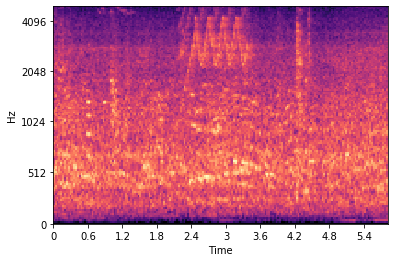

In [6]:
# CREATE SPECTROGRAM

# overrule settings in config
SAMPLING_RATE = sr_new  # Audio sampling rate, other parameters are hand-tuned for 44.1 kHz
CHUNK_SIZE = 882  # Spectrogram hop_size, 882 samples @ 44.1 kHz = 20 ms
FFT_SIZE = 2 * CHUNK_SIZE  # Spectrogram FFT window length

MEL_BANDS = 128  # 80 Number of mel frequency bands
MEL_FREQS = librosa.core.mel_frequencies(n_mels=MEL_BANDS)
#MEL_BANDS = 25
#MEL_FREQS = MEL_FREQS[0:25]

# current processing of the audio files
# default serval location
#audio_file = './dataset/audio/' + filename

audio = pydub.AudioSegment.from_file(audio_file).set_frame_rate(SAMPLING_RATE).set_channels(1)
audio = (np.fromstring(audio._data, dtype="int16") + 0.5) / (0x7FFF + 0.5) # convert to float

spec = librosa.feature.melspectrogram(audio, SAMPLING_RATE, n_fft=FFT_SIZE, fmin=0, fmax = 5000, 
                                      hop_length=CHUNK_SIZE, n_mels=MEL_BANDS) # MEL_BANDS
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # Ignore log10 zero division
    spec = librosa.core.perceptual_weighting(spec, MEL_FREQS, amin=1e-5, ref=1e-5,
                                             top_db=None)

spec = np.clip(spec, 0, 100)
#np.save(spec_file, spec.astype('float16'), allow_pickle=False)

librosa.display.specshow(spec,
                          y_axis='mel', sr=sr_new, fmin=0, fmax = 5000,
                          x_axis='time')

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:1702: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


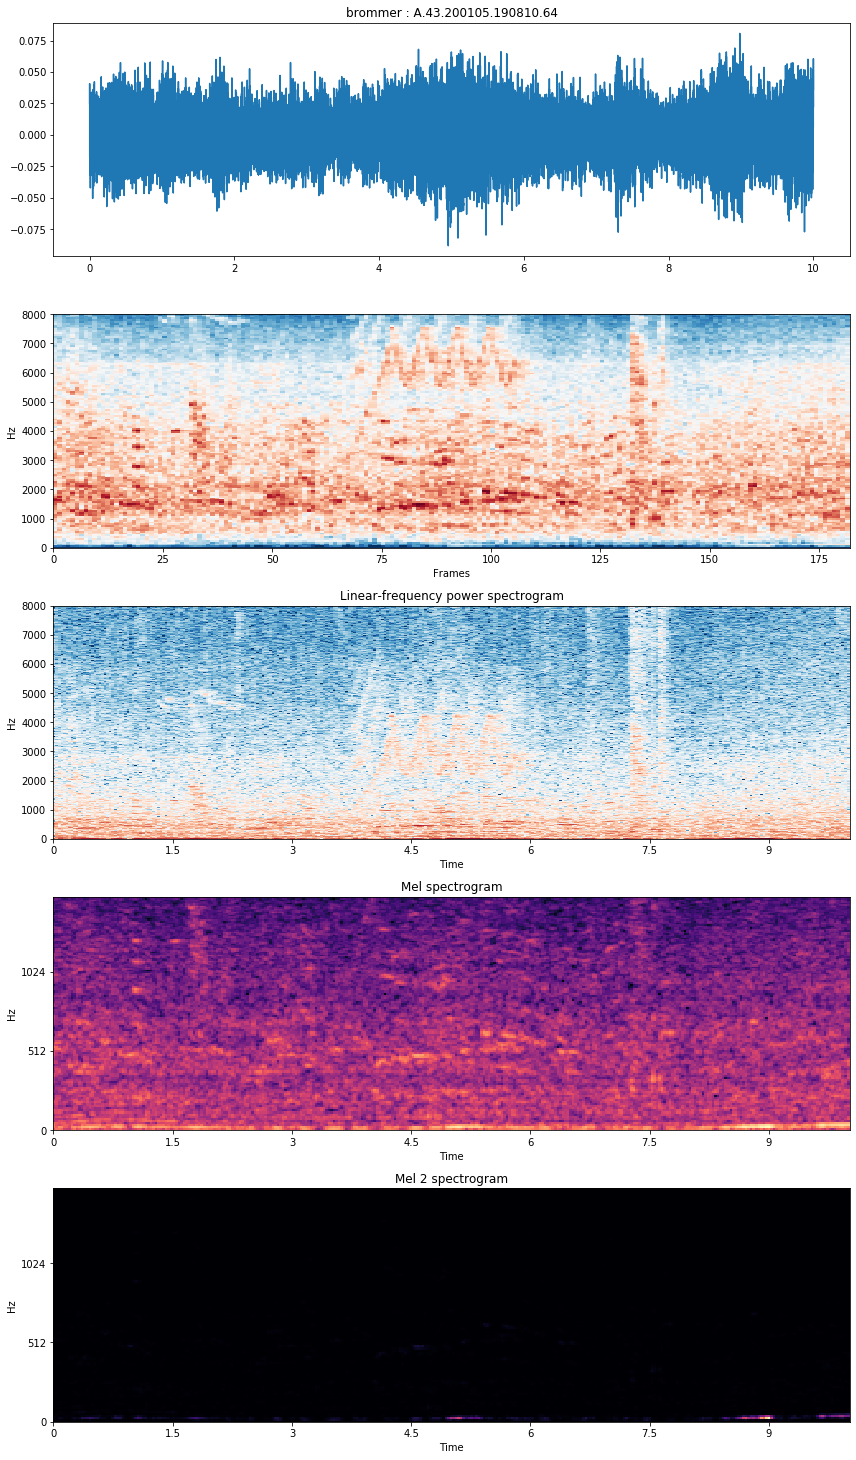

In [7]:
# You can reload this cell to get a different clip at every try
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# bigger figure size
matplotlib.rcParams['figure.figsize'] = [12.0, 24.0] # default : [6.0, 4.0]

import librosa.display

import IPython.display

#all_recordings = glob.glob('ESC-50/*/*.ogg')
#clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])    

plt.subplot(6, 1, 1)
plt.title('{0} : {1}'.format( category, filename))
plt.plot(np.arange(0, len(audio)) / SAMPLING_RATE, audio)

plt.subplot(6, 1, 2)
librosa.display.specshow(spec, sr = SAMPLING_RATE, x_axis='frames', y_axis='linear', cmap='RdBu_r')

# linear spectrogram
plt.subplot(6, 1, 3)
D = librosa.amplitude_to_db(librosa.stft(audio), ref=np.max)
librosa.display.specshow(D, sr=SAMPLING_RATE, y_axis='linear', x_axis='time', cmap='RdBu_r')
#plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

plt.subplot(6, 1, 4)
D = np.abs(librosa.stft(audio))**2
S = librosa.feature.melspectrogram(S=D, sr=SAMPLING_RATE, fmin=0, fmax=2000)
librosa.display.specshow(librosa.power_to_db(S,
                                              ref=np.max),
                          y_axis='mel', sr=SAMPLING_RATE, fmax=2000,
                          x_axis='time')
#plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

# log scale spectrogram
plt.subplot(6, 1, 5)
S = librosa.feature.melspectrogram(audio, sr=SAMPLING_RATE, fmin=0, fmax=2000)
librosa.display.specshow(S,
                          y_axis='mel', sr=SAMPLING_RATE, fmax=2000,
                          x_axis='time')
#plt.colorbar(format='%+2.0f dB')
plt.title('Mel 2 spectrogram')
plt.tight_layout()

    
IPython.display.Audio(filename=audio_file, rate=SAMPLING_RATE) 

In [8]:
# RESAMPLE 16 bit 16 kHz mono
import numpy as np
import scipy.signal
import librosa
import resampy

def resample(file):
    # Load in some audio
    x, sr_orig = librosa.load(file, sr=None, mono=True)

    sr_new = 16000
    # Or use the pre-built high-quality filter
    y = np.int16(resampy.resample(x, sr_orig, sr_new, filter='kaiser_best')) # 16 bit int
    return(y,sr_new)

In [9]:
# DOUBLE DISTANCE
import os
from pydub import AudioSegment

def doubledistance(file,file_new,db = 6):
    # db is the decibels we want to reduce
    # db = 6 doubles the distance of the recording from the source
    song = AudioSegment.from_wav(file)
    song = song - db
    # save song with different filename
    filename, file_extension = os.path.splitext(file_new)
    new_file = filename + "_db" + str(db) + file_extension
    song.export(new_file, format="wav")
    return

In [10]:
f = "../data/wav_samples_custom/b_brommers/B-Roos03.165538.57_dd12.wav"
fs = f.split('/')
f_new = '../'+fs[1]+'/'+fs[2]+'/'+fs[3]+'_trn'+'/'+fs[4]
f_new

directory = os.path.dirname(f_new) 
if not os.path.exists(directory):
    os.makedirs(directory)

In [11]:
# RESAMPLE AND ADJUST VOLUME FOR ALL WAVS IN FOLDER

import os
import random
from tqdm import tqdm
import soundfile as sf

path = "../data/wav_samples_custom"

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.wav' in file:
            files.append(os.path.join(r, file))

# proportion samples in train 
prop = 0.5
            
for f in tqdm(files):
    fs = f.split('/')
    # random choice between trn or eval label
    lbl = random.choices(['_trn','_eval'],[prop,1-prop])

    # trn eval split
    f_new = '../'+fs[1]+'/'+fs[2]+'/'+fs[3]+lbl[0]+'/'+fs[4]
    
    directory = os.path.dirname(f_new) 
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # resample 16 kHz mono
    y , sr = resample(f)
    # save wav file 16 bit int
    #librosa.output.write_wav(f_new, y, sr)
    sf.write(f_new, y, sr)
    
    # make copies doudle distance
    doubledistance(f,f_new, db = 6)  # 2x more distant
    doubledistance(f,f_new, db = 12) # 4x more distant
    doubledistance(f,f_new, db = 18) # 8x more distant


100%|██████████| 3440/3440 [24:46<00:00,  2.31it/s]
